# Bow-Tie I

In this toy model, we will show how Dlink works in simple directed, sparse networks with two clusters bonded by a single node. This is an expected topology for nodes with overlapping community memberships (NOC). 

First, let's import some libraries.

In [1]:
T = True
F = False
# Stadard python libs ----
import numpy as np
# Personal libs ----
from networks.toy import TOY
from modules.hierarmerge import Hierarchy
from modules.hierarentropy import Hierarchical_Entropy
from modules.colregion import colregion
from modules.discovery import discovery_channel
from plotting_jupyter.plotting_H import Plot_H
from various.network_tools import get_labels_from_Z, get_best_kr, omega_index_format, get_best_kr_equivalence, skim_partition

The make_toys function, as its name suggests, creates the networks that we are going to use in this example. It produces 12 networks, but we will just cover four: toy_0, toy_6, toy_3, and toy_1. As it can be read in the code, the networks with several nodes have a basic layout with two main clusters with strong connections. There is also node A which can have six out of the twelve connections with two different strengths. The algorithm places the six connections in a sequence.

In [2]:
def make_toys(linkage, **kwargs):
  ww = 1
  ws = 5

  toy = np.array(
    [
      [0, -1, -1, -1, -1, -1, -1],
      [-1, 0, ws, ws, 0, 0, 0],
      [-1, 0, 0, ws, 0, 0, 0],
      [-1 ,ws ,0, 0, 0, 0 ,0],
      [-1, 0, 0, 0, 0, ws, ws],
      [-1, 0, 0, 0, ws, 0, 0],
      [-1, 0, 0, 0, ws, ws, 0]
    ]
  )

  n = (toy.shape[0] - 1) * 2
  A = np.array(
    [
      ww, ww, ww,
      ws, ws, ws,
      0, 0, 0,
      0, 0, 0
    ]
  )
  x = np.arange(n)
  NETS = []
  rows, cols = np.where(toy == -1)
  for i in np.arange(n):
    wheel = np.zeros(n)
    wheel[i:] = x[:(n-i)]
    wheel[:i] = x[(n-i):]
    wheel = wheel.astype(int)
    toy_copy = toy.copy()
    toy_copy[rows, cols] = A[wheel]
    NETS.append(
      TOY(toy_copy.astype(float), linkage, **kwargs)
    )
  return n, NETS

Here, we set up the code to run the link communities, compute the quality functions, and extract the node hierarchy, as usual.

In [3]:
linkage = "single"
nlog10 = F
lookup = F
prob = F
cut = F
mode = "ZERO"
topology = "MIX"
index = "Hellinger2"
discovery = "discovery_7"
opt_score = ["_D"]
nodes = 7

properties = {
  "nlog10" : nlog10,
  "lookup" : lookup,
  "prob" : prob,
  "cut" : cut,
  "topology" : topology,
  "index" : index,
  "mode" : mode
}

N, NETS = make_toys(linkage, **properties)
original_labels = np.array(["A", "B", "C", "D", "E", "F", "G"])
labels_dict = dict()
for i in np.arange(nodes):
  labels_dict[i] = original_labels[i]
toy_names = np.arange(N).astype(int).astype(str)

HS = []
for i, net in enumerate(NETS):
  print(f"\n\n\tAnalysing toy: {toy_names[i]}")
  net.set_labels(original_labels)
  h = Hierarchy(
    net, net.A, net.A, np.zeros(net.A.shape),
    nodes, linkage, mode
  )
  ## Compute features ----
  h.BH_features_cpp_no_mu()
  ## Compute link entropy ----
  h.link_entropy_cpp("short", cut=cut)
  ## Compute lq arbre de merde ----
  h.la_abre_a_merde_cpp(h.BH[0])
  ## Compute node entropy ----
  h.node_entropy_cpp("short", cut=cut)
  # Set labels to network ----
  L = colregion(net, labels=net.labels)
  L.get_regions()
  h.set_colregion(L)
  HS.append(h)
  # Entropy ----
  S = Hierarchical_Entropy(h.Z, h.nodes, list(range(h.nodes)))
  S.Z2dict("short")
  h.entropy = [
    h.node_entropy, h.node_entropy_H,
    h.link_entropy, h.link_entropy_H
  ]



	Analysing toy: 0
Compute link hierarchical agglomeration ----
Mu-free

	link entropy :  Sh : 0.2656, and Sv : 0.7344


	link entropy H: Sh : 0.2137, and Sv : 0.7863

Compute node hierarchy ----
Starting Z2dict
Level information
Vertex entropy
Vertex entropy H
Level entropy
Level entropy H
Number of vertices in the tree: 29
50%
Adding exceptional nodes.
Commencer: la abre a merde

	Node entropy :  Sh : 0.1006, and Sv : 0.8994

Voila, bon ami
Starting Z2dict
Level information
Vertex entropy
Vertex entropy H
Level entropy
Level entropy H
Number of vertices in the tree: 13

	Node entropy H: Sh : 0.0761, and Sv : 0.9239



	Analysing toy: 1
Compute link hierarchical agglomeration ----
Mu-free
Starting Z2dict
Level information
Vertex entropy
Vertex entropy H
Level entropy
Level entropy H
Number of vertices in the tree: 29

	link entropy :  Sh : 0.2557, and Sv : 0.7443


	link entropy H: Sh : 0.1800, and Sv : 0.8200

Compute node hierarchy ----
50%
Commencer: la abre a merde
Voila, bon ami

In this network, node A has only outlinks. In the first plot, we see the link communities colored in the adjacency matrix. The matrix was arranged using the node dendrogram. The second plot shows that nodes BCD and EFG are forming two clusters. Node A, which is not colored, was left behind, and as it is seen in the dendrogram (third), it is clustered only once the other two communities are merged. In the last plot, we can see the link membership of the network and notice how the links from A belong to the two groups.

{}
{0: ['B', 'C'], 1: ['E', 'F', 'G']}
Printing network space
{}
{0: ['B', 'C'], 1: ['E', 'F', 'G']}
Printing network space
{}
{0: ['B', 'C'], 1: ['E', 'F', 'G']}
Printing network space


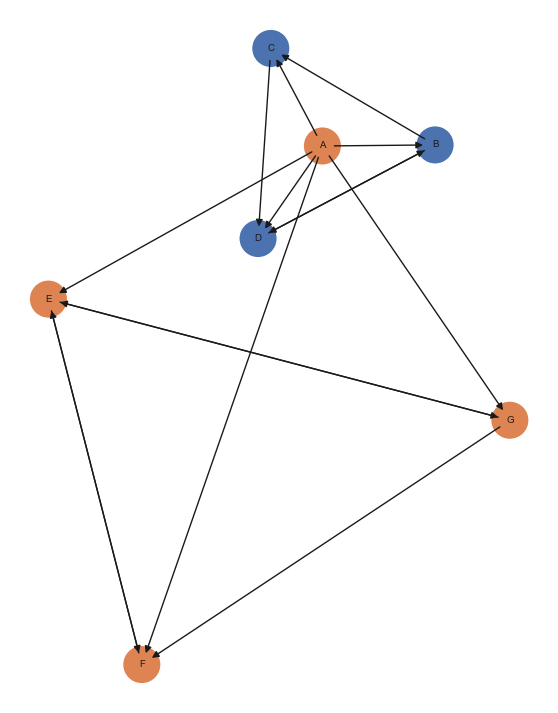

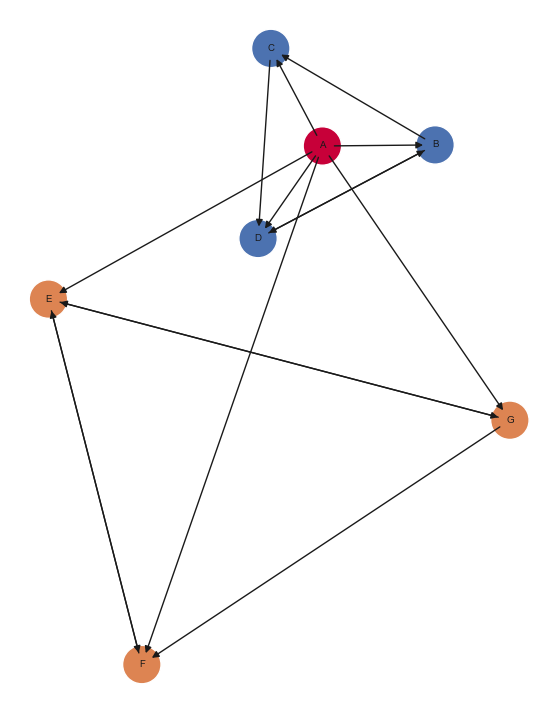

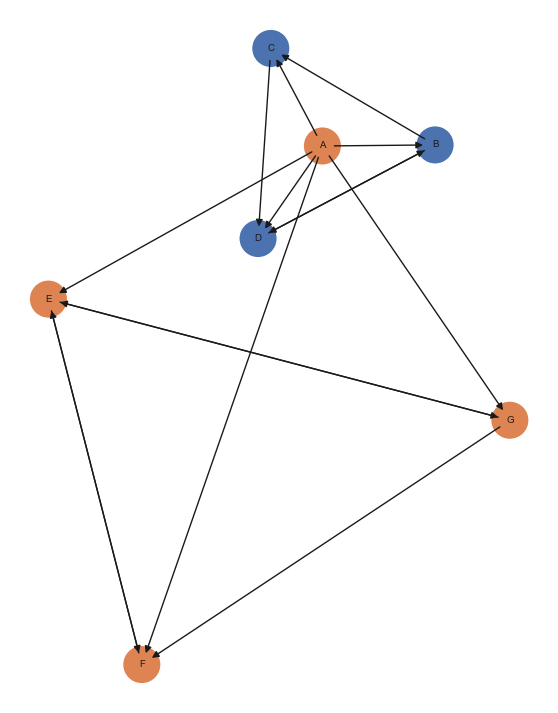

In [4]:
score = "_D"
i = 0
# Plot H ----
plot_h = Plot_H(NETS[i], HS[i])
# Get best k and r ----
K, R, HT = get_best_kr_equivalence(score, HS[i])
r = R[K == np.min(K)][0]
k = K[K == np.min(K)][0]                                 # <------ Very interesting. Why?
rlabels = get_labels_from_Z(HS[i].Z, r)
rlabels = skim_partition(rlabels)
for direction in ["source", "target", "both"]:
  noc, subcover, sizes, rlabels2 = discovery_channel[discovery](HS[i], k, rlabels, direction=direction, index=index)
  # Which are the NOCs?
  print(subcover)
  cover = omega_index_format(
    rlabels, subcover, HS[i].colregion.labels[:HS[i].nodes]
  )
  # What is the cover?
  print(cover)
  # Plots
  plot_h.plot_network_kk(
    HS[i], rlabels2, subcover, sizes, HS[i].colregion.labels,
    ang=0, score=score, font_size=7, cmap_name="deep", front_edges=True
  )

This example is similar to the first, but node A has only inlinks.

{}
{0: ['C', 'D'], 1: ['E', 'F', 'G']}
Printing network space
{}
{0: ['C', 'D'], 1: ['E', 'F', 'G']}
Printing network space
{}
{0: ['C', 'D'], 1: ['E', 'F', 'G']}
Printing network space


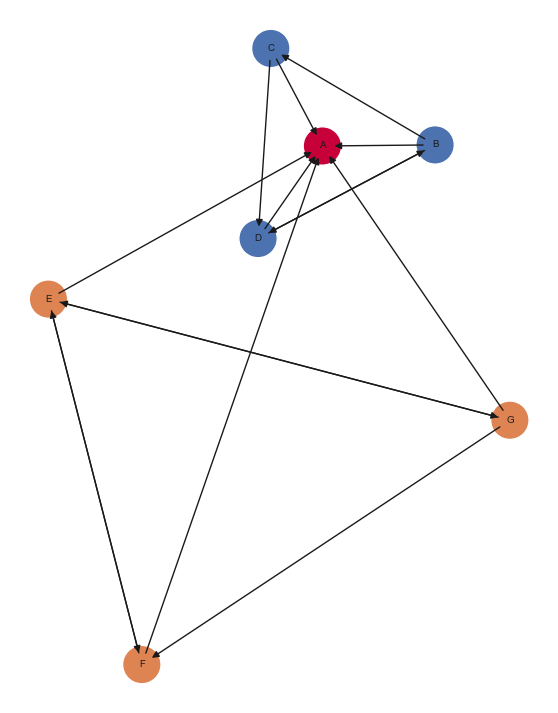

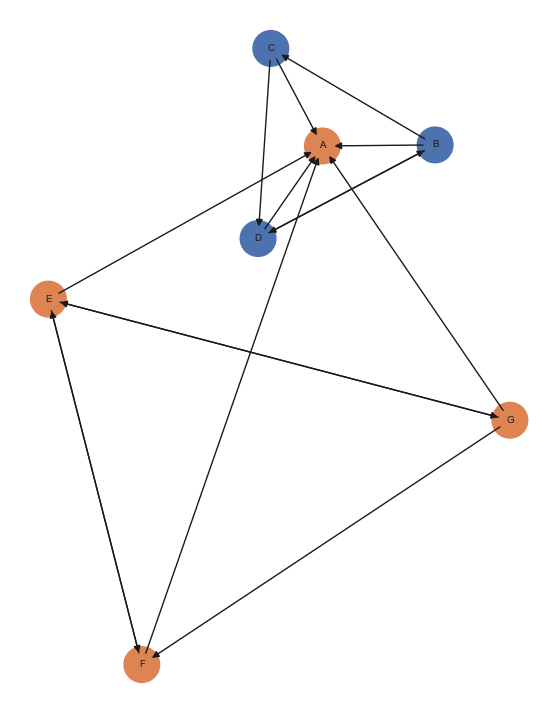

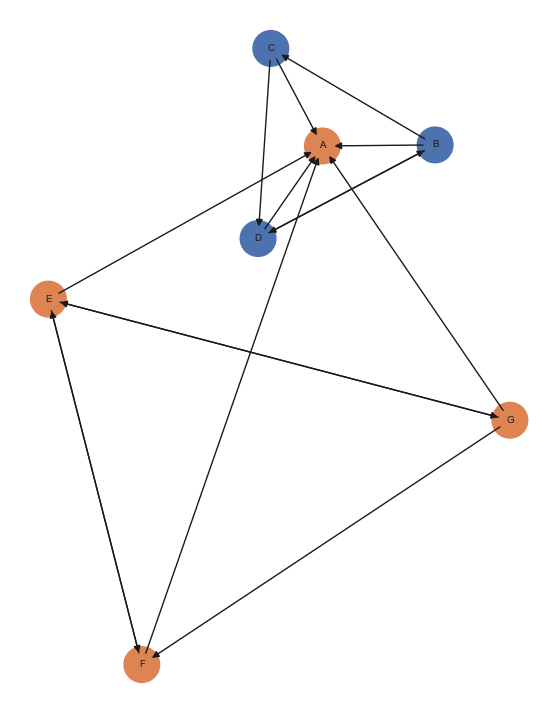

In [5]:
i = 6
# Plot H ----
plot_h = Plot_H(NETS[i], HS[i])
# Get best k and r ----
K, R, HT = get_best_kr_equivalence(score, HS[i])
r = R[K == np.min(K)][0]
k = K[K == np.min(K)][0]                                        # <------ Very interesting. Why?
rlabels = get_labels_from_Z(HS[i].Z, r)
rlabels = skim_partition(rlabels)
for direction in ["source", "target", "both"]:
  noc, subcover, sizes, rlabels2 = discovery_channel[discovery](HS[i], k, rlabels, direction=direction, index=index)
  # Which are the NOCs?
  print(subcover)
  cover = omega_index_format(
    rlabels, subcover, HS[i].colregion.labels[:HS[i].nodes]
  )
  # What is the cover?
  print(cover)
  # Plots
  plot_h.plot_network_kk(
    HS[i], rlabels2, subcover, sizes, HS[i].colregion.labels,
    ang=0, score=score, font_size=7, cmap_name="deep", front_edges=True
  )

In this example, node A's links create a flow that has the topological role of connecting the two categories in only one direction.

{}
{0: ['B', 'C', 'D'], 1: ['E', 'F', 'G']}
Printing network space
{}
{0: ['B', 'C', 'D'], 1: ['E', 'F', 'G']}
Printing network space
{'A': [0, 1]}
{0: ['B', 'C', 'D', 'A'], 1: ['E', 'F', 'G', 'A']}
Printing network space


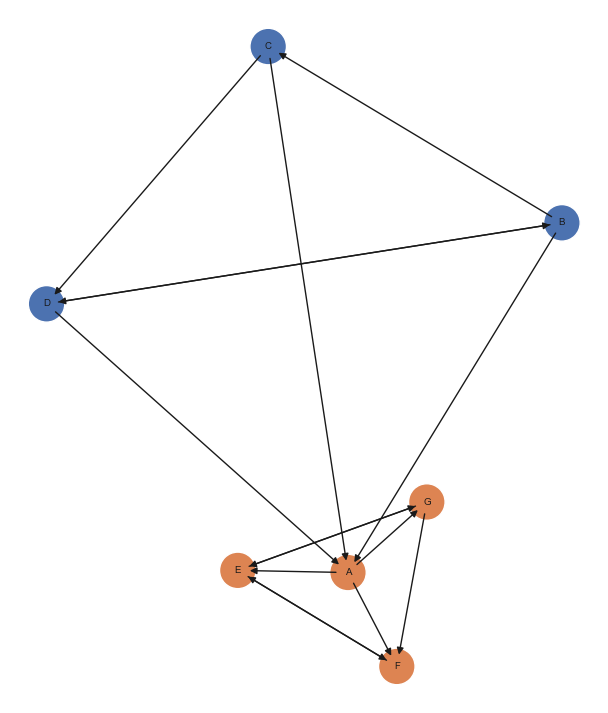

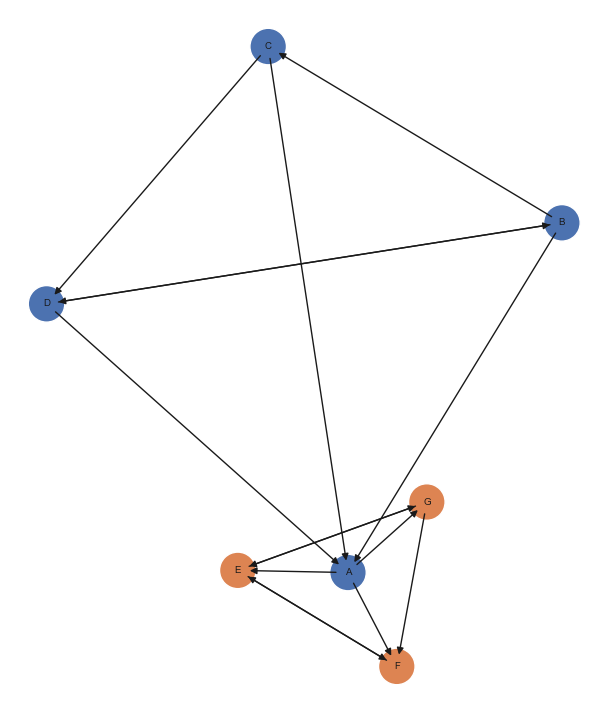

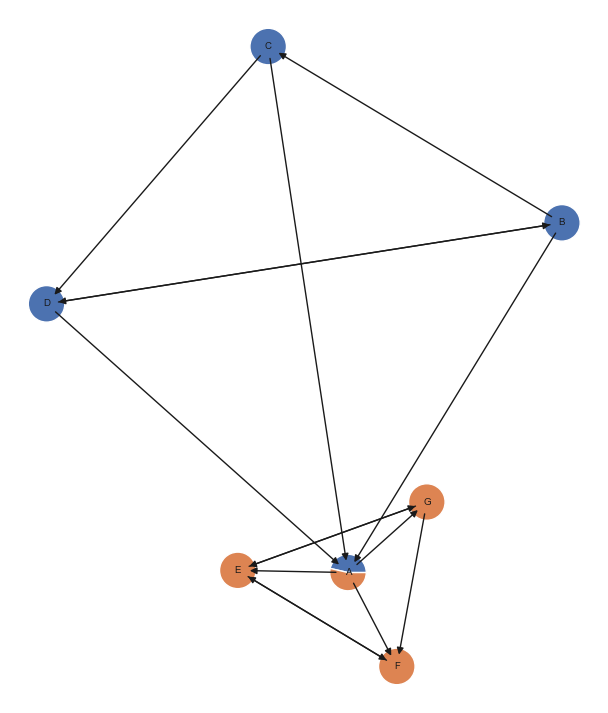

In [6]:
i = 3
# Plot H ----
plot_h = Plot_H(NETS[i], HS[i])
# Get best k and r ----
K, R, HT = get_best_kr_equivalence(score, HS[i])
r = R[K == np.min(K)][0]
k = K[K == np.min(K)][0]                                          # <------ Very interesting. Why?
rlabels = get_labels_from_Z(HS[i].Z, r)
rlabels = skim_partition(rlabels)
for direction in ["source", "target", "both"]:
  noc, subcover, sizes, rlabels2 = discovery_channel[discovery](HS[i], k, rlabels, direction=direction, index=index)
  # Which are the NOCs?
  print(subcover)
  cover = omega_index_format(
    rlabels, subcover, HS[i].colregion.labels[:HS[i].nodes]
  )
  # What is the cover?
  print(cover)
  # Plots
  plot_h.plot_network_kk(
    HS[i], rlabels2, subcover, sizes, HS[i].colregion.labels,
    ang=0, score=score, font_size=7, cmap_name="deep", front_edges=True
  )

Lastly, in the last example, the network has some in- and outlinks. We can see a fascinating phenomenon regarding link communities in sparse directed networks. We can see that in the best partition, only one group appears (second plot). In the last plot, we can see that most of the links but one are colored in the best partition. The connection from D to B remains unclustered because it needs neighbor links! The link neighborhood is empty because D has no other outlink and B no inlink. Since it cannot be compared, it remains isolated until the similarity threshold in the hierarchical agglomeration process clusters it to another link community, but this happens at the end.

We can see that, even though the blue link community picture shows that nodes A & C form a community because they have in- and outlinks, they are not classified into a cluster, as also seen in the node dendrogram (third). This is an example that finding the right node community from the link community partition still needs exploration.

{}
{0: ['A', 'C'], 1: ['E', 'F', 'G']}
Printing network space
{}
{0: ['A', 'C'], 1: ['E', 'F', 'G']}
Printing network space
{}
{0: ['A', 'C'], 1: ['E', 'F', 'G']}
Printing network space


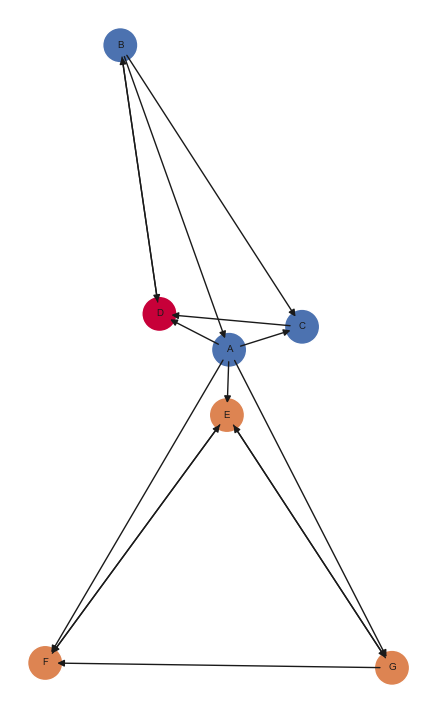

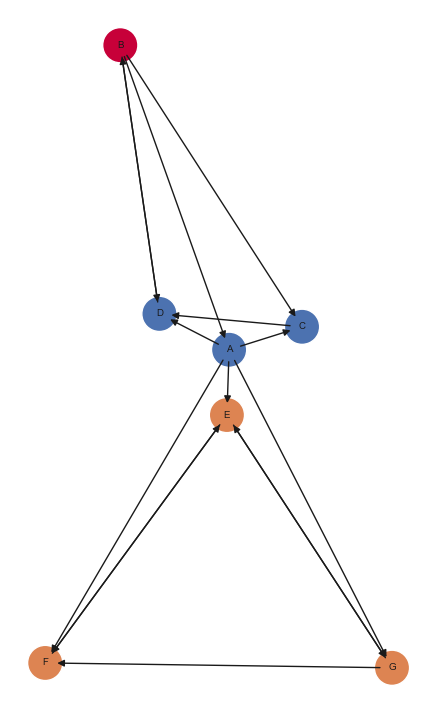

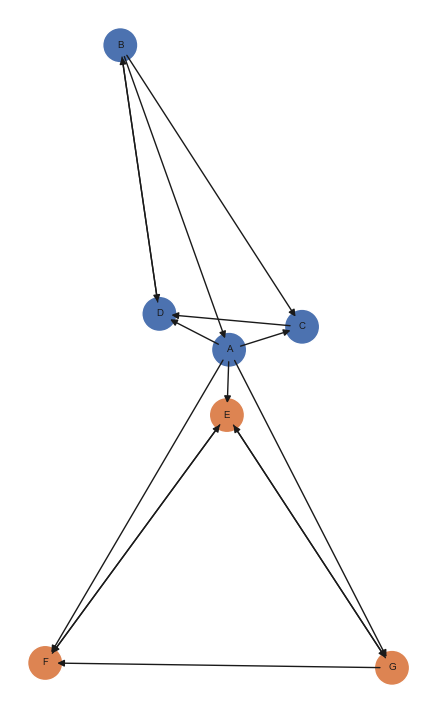

In [7]:
i = 1
# Plot H ----
plot_h = Plot_H(NETS[i], HS[i])
# Get best k and r ----
K, R, HT = get_best_kr_equivalence(score, HS[i])
r = R[K == np.min(K)][0]
k = K[K == np.min(K)][0]                                         # <------ Very interesting. Why?
rlabels = get_labels_from_Z(HS[i].Z, r)
rlabels = skim_partition(rlabels)
for direction in ["source", "target", "both"]:
  noc, subcover, sizes, rlabels2 = discovery_channel[discovery](HS[i], k, rlabels, direction=direction, index=index)
  # Which are the NOCs?
  print(subcover)
  cover = omega_index_format(
    rlabels, subcover, HS[i].colregion.labels[:HS[i].nodes]
  )
  # What is the cover?
  print(cover)
  # Plots
  plot_h.plot_network_kk(
    HS[i], rlabels2, subcover, sizes, HS[i].colregion.labels,
    ang=0, score=score, font_size=7, cmap_name="deep", front_edges=True
  )